# Zero Shot Learning
In this notebook, we give an example of zero shot learning on bubble dataset. We generate the dataset by normal distribution.
We have the follow position per class:
- top left (seen),
- top right (seen),
- bottom left (seen),
- bottom right (seen),
- middle (unseen).

By the above list the only unseen class of the data is at the middle (position). Next we initialize and train a Feed Forward
(FF) neural network for zero shot task. Finally, we visualize the results by cost/score curve and class space.

In [1]:
from algomorphism.datasets.generated_data import BubbleDataset
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
import algomorphism as am
from sklearn.preprocessing import LabelBinarizer
from algomorphism.figures.nn import pca_denoising_figure
from algomorphism.methods.nn import pca_denoising_preprocessing
from algomorphism.figures.nn import multiple_models_history_figure

In [2]:
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-10-26 18:54:44.051143: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 18:54:44.099292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 18:54:44.100114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Generate Data
Generate Bubble Dataset and plot some examples.

In [ ]:
bd = BubbleDataset(n_data=1000, sigma=0.25)

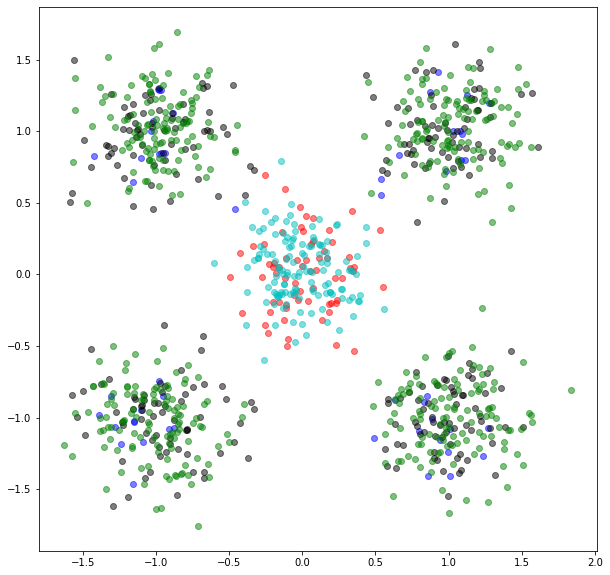

In [4]:
plt.figure(figsize=(10,10))
for x, y, y_hot in bd.val.seen:
    plt.plot(x[:,0], x[:,1], 'ob', alpha=0.5)

for x, y, y_hot in bd.val.unseen:
    plt.plot(x[:,0], x[:,1], 'or', alpha=0.5)

for x, y, y_hot in bd.test.seen:
    plt.plot(x[:,0], x[:,1], 'ok', alpha=0.5)

for x, y, y_hot in bd.test.unseen:
    plt.plot(x[:,0], x[:,1], 'oc', alpha=0.5)

for x, y, y_hot in bd.train:
    plt.plot(x[:,0], x[:,1], 'og', alpha=0.5)

## Initialize 1 Nearest Neighbors Classifier
Train 1 Nearest Neighbors Classifier (1NNC) for post processes of FeedForward output to compute the score.

In [5]:
knn = KNeighborsClassifier(1)
y_one_hot = LabelBinarizer().fit_transform(list(bd.data_dict.keys()))
knn.fit(
    [v['class_emb'] for v in bd.data_dict.values()],
    y_one_hot
)


KNeighborsClassifier(n_neighbors=1)

## Initialize & Train FF Neural Network

In [6]:
class FeedForward(tf.Module, am.base.BaseNeuralNetwork):
    def __init__(self, knn, dataset):
        tf.Module.__init__(self, name='ff')

        status = [
            [0],
            [1],
            [2]
        ]

        self.knn = knn
        self.score_mtr = am.base.MetricBase(self,
                                    [tf.keras.metrics.CategoricalAccuracy()],
                                    status,
                                    [0]
                                    )

        self.cost_mtr = am.base.MetricBase(self,
                                    [tf.keras.metrics.MeanSquaredError()],
                                    status,
                                    [0],
                                    1
                                    )
        self.cost_loss = am.base.LossBase(self,
                                    [tf.keras.losses.MeanSquaredError()],
                                    status,
                                    [0]
                                    )
        am.base.BaseNeuralNetwork.__init__(self, status=status, optimizer='Adam', dataset=dataset,
                                           learning_rate=1e-2)
        self.fc1 = am.layers.FC(2, 128)
        self.fc2 = am.layers.FC(128, 256)
        self.fc3 = am.layers.FC(256, 512)
        self.fc4 = am.layers.FC(512, 1024)
        self.out = am.layers.FC(1024, 2)

    def __call__(self, inputs, is_score=False):
        x = self.fc1(inputs[0])
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        y = self.out(x)
        if is_score:
            y = self.knn.predict(y)
        return tuple([y])

In [7]:
ff = FeedForward(knn=knn, dataset=bd)

In [8]:
ff.train(bd, 60, print_types=['train', 'val'])

2021-10-26 18:54:46.423470: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 1 finished
train cost: 9.401792526245117
train score: 0.8583333492279053
val seen cost: 9.755661964416504
val seen score: 0.807692289352417
val unseen cost: 4.6641926765441895
val unseen score: 0.0
val harmonic: 0.0
Epoch 2 finished
train cost: 63.18088150024414
train score: 0.0
val seen cost: 66.36853790283203
val seen score: 0.0
val unseen cost: 23.110687255859375
val unseen score: 0.0
val harmonic: nan
Epoch 3 finished
train cost: 19.544673919677734
train score: 0.010416666977107525
val seen cost: 19.309051513671875
val seen score: 0.057692307978868484
val unseen cost: 6.244312763214111
val unseen score: 0.0
val harmonic: 0.0
Epoch 4 finished
train cost: 14.021743774414062
train score: 0.004166666883975267
val seen cost: 13.124781608581543
val seen score: 0.0
val unseen cost: 6.115654945373535
val unseen score: 0.0
val harmonic: nan
Epoch 5 finished
train cost: 6.682896137237549
train score: 0.25208333134651184
val seen cost: 6.377901077270508
val seen score: 0.25
val unseen c

## Results Visualization
1. Plot cost/score curves for train and validation examples,
2. plot 1KNN space with validation and test outputs of FF.

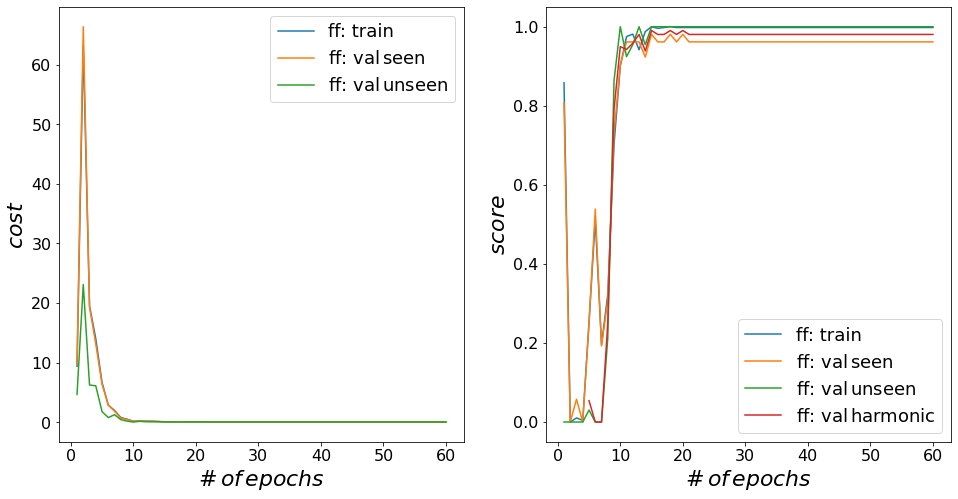

In [9]:
multiple_models_history_figure([ff])

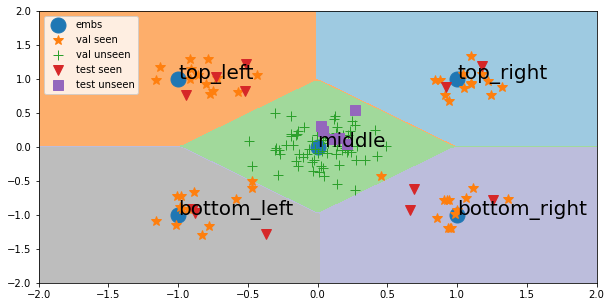

In [10]:
pca_vl_s, pca_ts_s, pca_vl_u, pca_ts_u, pca_emb, knn_pca = pca_denoising_preprocessing(ff, bd,
                                    [v['class_emb'] for v in bd.data_dict.values()], y_one_hot, pca_emb_idxs=[4, 3, 2, 1, 0])

pca_denoising_figure(pca_vl_s, pca_ts_s, pca_vl_u, pca_ts_u, pca_emb, knn_pca,
                     list(bd.data_dict.keys()), pca_emb_idxs=[4, 3, 2, 1, 0])
